## Setup

In [ ]:
import functools
import os
import matplotlib
import time 

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
import os 
import subprocess

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.12.0
TF Hub version:  0.13.0
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from matplotlib import gridspec
!unzip /content/image_files.zip

Archive:  /content/image_files.zip
   creating: image_files/
  inflating: __MACOSX/._image_files  
  inflating: image_files/.DS_Store   
  inflating: __MACOSX/image_files/._.DS_Store  
   creating: image_files/content/
   creating: image_files/style/
  inflating: image_files/content/dog.jpg  
  inflating: __MACOSX/image_files/content/._dog.jpg  
  inflating: image_files/content/person.jpg  
  inflating: __MACOSX/image_files/content/._person.jpg  
  inflating: image_files/content/painting.jpg  
  inflating: __MACOSX/image_files/content/._painting.jpg  
  inflating: image_files/content/building.jpg  
  inflating: __MACOSX/image_files/content/._building.jpg  
  inflating: image_files/content/car.jpg  
  inflating: __MACOSX/image_files/content/._car.jpg  
  inflating: image_files/style/4.jpg  
  inflating: __MACOSX/image_files/style/._4.jpg  
  inflating: image_files/style/5.jpg  
  inflating: __MACOSX/image_files/style/._5.jpg  
  inflating: image_files/style/2.jpg  
  inflating: __MACOSX

## Import TF Hub module

In [ ]:
# Load TF Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

The signature of this hub module for image stylization is:
```
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]
```
Where `content_image`, `style_image`, and `stylized_image` are expected to be 4-D Tensors with shapes `[batch_size, image_height, image_width, 3]`.

In the current example we provide only single images and therefore the batch dimension is 1, but one can use the same module to process more images at the same time.

The input and output values of the images should be in the range [0, 1].

The shapes of content and style image don't have to match. Output image shape
is the same as the content image shape.

## Image load and Visualization functions

In [ ]:


def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  # image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  image_path = image_url
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


## Get Single Inference

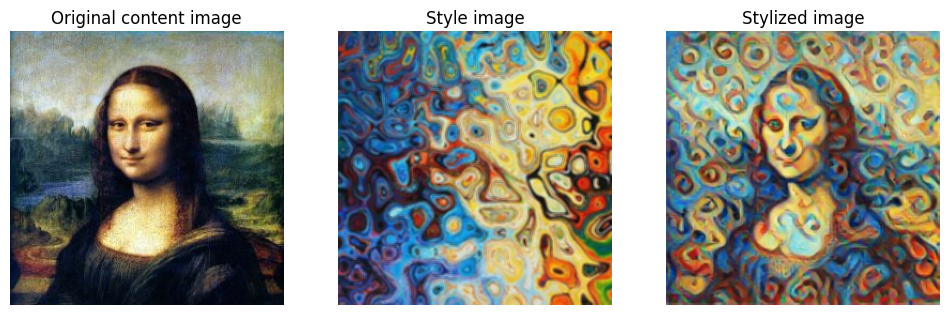

In [ ]:


# content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
# style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
content_image_file_path = '/content/mona_lisa_256.jpg'  # @param {type:"string"}
style_image_file_path = '/content/style_256.jpg'  # @param {type:"string"}
output_file_name = '/content/output_256.jpg'  # @param {type:"string"}

content_image_url = content_image_file_path
style_image_url = style_image_file_path

output_image_size = 256  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
# show_n([content_image, style_image], ['Content image', 'Style image'])



# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]


# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])
# Assume `image_tensor` is the `EagerTensor` that you want to save
image_array = tf.squeeze(stylized_image).numpy()  # Convert to numpy array and remove extra dimensions
image_array = (image_array * 255.0).astype('uint8')  # Scale pixel values to [0, 255] and convert to uint8
image = Image.fromarray(image_array)  # Create PIL Image object
image.save(output_file_name)  

## Get Image Tuples

In [ ]:

content_dir = "/content/image_files/content" # @param {type:"string"}
style_dir = "/content/image_files/style" # @param {type:"string"}
out_dir = "/content/fast_style" # @param {type:"string"}

# to get image tuples of only one style
only_one_style_all_images = False
style_image_name = ["1.jpg"]

image_tuples = []

if os.path.exists(out_dir):
  print("output directory already exist !")

elif only_one_style_all_images:
  for s in style_image_name:
    if ".DS_Store" in s:
      continue
    sn = s.split(".")[0]
    for c in os.listdir(content_dir):
      if ".DS_Store" in c:
        continue
      cn = c.split(".")[0]
      fsp = os.path.join(style_dir,s)
      fcp = os.path.join(content_dir,c)
      
      on = "content_"+str(cn)+"_style_"+str(sn)+".jpg"
      op = os.path.join(out_dir,on)
      image_tuples.append((fcp,fsp,op))

else:
  for s in os.listdir(style_dir):
    if ".DS_Store" in s:
      continue
    sn = s.split(".")[0]
    for c in os.listdir(content_dir):
      if ".DS_Store" in c:
        continue
      cn = c.split(".")[0]
      fsp = os.path.join(style_dir,s)
      fcp = os.path.join(content_dir,c)
      
      on = "content_"+str(cn)+"_style_"+str(sn)+".jpg"
      op = os.path.join(out_dir,on)
      image_tuples.append((fcp,fsp,op))

    # also make output directory if missing 
    subprocess.run("mkdir "+str(out_dir), shell = True)

for x in image_tuples:
  print(x)

('/content/image_files/content/painting.jpg', '/content/image_files/style/1.jpg', '/content/fast_style/content_painting_style_1.jpg')
('/content/image_files/content/dog.jpg', '/content/image_files/style/1.jpg', '/content/fast_style/content_dog_style_1.jpg')
('/content/image_files/content/building.jpg', '/content/image_files/style/1.jpg', '/content/fast_style/content_building_style_1.jpg')
('/content/image_files/content/person.jpg', '/content/image_files/style/1.jpg', '/content/fast_style/content_person_style_1.jpg')
('/content/image_files/content/car.jpg', '/content/image_files/style/1.jpg', '/content/fast_style/content_car_style_1.jpg')
('/content/image_files/content/painting.jpg', '/content/image_files/style/2.jpg', '/content/fast_style/content_painting_style_2.jpg')
('/content/image_files/content/dog.jpg', '/content/image_files/style/2.jpg', '/content/fast_style/content_dog_style_2.jpg')
('/content/image_files/content/building.jpg', '/content/image_files/style/2.jpg', '/content/fast

## Multiple inferences

In [ ]:
print("Total Inferences: {}".format(len(image_tuples)))
count = 0
time_array = []
for t in image_tuples:
  cp, sp, op = t[0],t[1],t[2]
  count += 1
  print("Processing Inference :{}/{} for Image : {}".format(count, len(image_tuples), op))

  content_image_file_path = cp
  style_image_file_path = sp
  output_file_name = op

  content_image_url = content_image_file_path
  style_image_url = style_image_file_path

  output_image_size = 256 
  content_img_size = (output_image_size, output_image_size)
  style_img_size = (256, 256)

  content_image = load_image(content_image_url, content_img_size)
  style_image = load_image(style_image_url, style_img_size)
  style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
  # show_n([content_image, style_image], ['Content image', 'Style image'])

  # time
  start_time = time.time()
  outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
  end_time = time.time()
  tat_time = end_time - start_time
  tat_time = tat_time*1000
  time_array.append(tat_time)


  stylized_image = outputs[0]

  # show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])
  image_array = tf.squeeze(stylized_image).numpy()  # Convert to numpy array and remove extra dimensions
  image_array = (image_array * 255.0).astype('uint8')  # Scale pixel values to [0, 255] and convert to uint8
  image = Image.fromarray(image_array)  # Create PIL Image object
  image.save(output_file_name) 

print(time_array)
tat_mean = np.mean(np.array(time_array))
print("average time to process an image in milliseconds : {}".format(tat_mean))


Total Inferences: 25
Processing Inference :1/25 for Image : /content/fast_style/content_painting_style_1.jpg
Processing Inference :2/25 for Image : /content/fast_style/content_dog_style_1.jpg
Processing Inference :3/25 for Image : /content/fast_style/content_building_style_1.jpg
Processing Inference :4/25 for Image : /content/fast_style/content_person_style_1.jpg
Processing Inference :5/25 for Image : /content/fast_style/content_car_style_1.jpg
Processing Inference :6/25 for Image : /content/fast_style/content_painting_style_2.jpg
Processing Inference :7/25 for Image : /content/fast_style/content_dog_style_2.jpg
Processing Inference :8/25 for Image : /content/fast_style/content_building_style_2.jpg
Processing Inference :9/25 for Image : /content/fast_style/content_person_style_2.jpg
Processing Inference :10/25 for Image : /content/fast_style/content_car_style_2.jpg
Processing Inference :11/25 for Image : /content/fast_style/content_painting_style_5.jpg
Processing Inference :12/25 for I

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp -r /content/fast_style /content/drive/MyDrive/fast_style_256